# Importing all the libraries

In [ ]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [ ]:
# Setting the path
path = '../archive/kaggle_data_for_face_masks'
# Finding the categories
category = os.listdir(path)
# Creating a label for each category
label = [i for i in range(len(category))]

label_dict = dict(zip(category,label))

print(label_dict)
print(category)
print(label)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


## Data Preprocessing

In [ ]:
imageSize = 100
data = []
target_var = []

for c in category:
    data_path = os.path.join(path, c)
    images = os.listdir(data_path)
        
    for img in images:
        img = os.path.join(data_path,img)
        img = cv2.imread(img)

        try:
            #Coverting into gray scale
            gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            #resizing the image
            resize_img = cv2.resize(gray_img,(imageSize,imageSize))
            #appending the image into data list
            data.append(resize_img)
            #creating a target variable for each image
            target_var.append(label_dict[c])

        except Exception as e:
            print('Exception:',e)            

In [ ]:
# Normalizing the data images
data = np.array(data)/255.0
#Reshaping the data into required format
data = np.reshape(data,(data.shape[0],imageSize,imageSize,1))
target = np.array(target_var)

#Converting the target variable to categorical dataset
target = np_utils.to_categorical(target)

In [ ]:
# Data Augmentation Object
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Model Architecture

In [ ]:
# Model Architecture
model=Sequential()

#First Convolution layer followed by Relu and Max Pooling
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second Convolution layer followed by Relu and Max Pooling
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten the second convolution layer
model.add(Flatten())
model.add(Dropout(0.5))

#Adding a Dense layer
model.add(Dense(50,activation='relu'))

#Output layer for two categories
model.add(Dense(2,activation='sigmoid'))

# Compiling the model using binary crossentropy and adam optimizer 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Splitting the dataset into 80:20 ratio of train and test respectively

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data,target,test_size=0.2)

In [ ]:
# train_y = tf.one_hot(train_y, depth=2)
# test_y = tf.one_hot(test_y, depth=2)
# tf.config.experimental_run_functions_eagerly(True)

In [ ]:
train_y

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Fitting the model

In [ ]:
cp = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
hist = model.fit(train_x,train_y,epochs=25,callbacks=[cp],validation_split=0.2)

Epoch 1/25
152/152 [==============================] - 91s 596ms/step - loss: 0.6327 - accuracy: 0.6303 - val_loss: 0.5989 - val_accuracy: 0.6667
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/25
152/152 [==============================] - 90s 594ms/step - loss: 0.5582 - accuracy: 0.7155 - val_loss: 0.5619 - val_accuracy: 0.6890
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/25
152/152 [==============================] - 90s 595ms/step - loss: 0.4682 - accuracy: 0.7724 - val_loss: 0.4329 - val_accuracy: 0.8246
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/25
152/152 [==============================] - 89s 585ms/step - loss: 0.3522 - accuracy: 0.8463 - val_loss: 0.4013 - val_accuracy: 0.8230
INFO:tensorflow:Assets written to: model-004.model\assets
Epoch 5/25
152/152 [==============================] - 90s 594ms/step - loss: 0.2642 - accuracy: 0.8852 - val_loss: 0.3035 - val_accuracy: 0.8883
INFO:tensorflow:Assets written to: model-00

In [ ]:
#Predicting the model on test dataset
pred_y = model.predict(test_x)

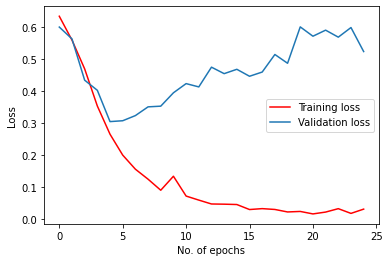

In [ ]:
# Plotting a curve between training and validation loss
plt.plot(hist.history['loss'],'r',label='Training loss')
plt.plot(hist.history['val_loss'],label='Validation loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

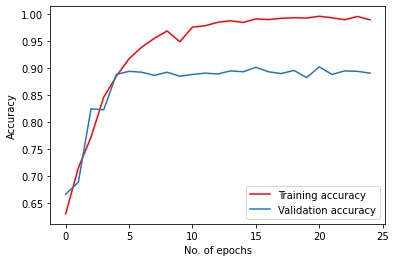

In [ ]:
#Plotting a curve between training and validation accuracy
plt.plot(hist.history['accuracy'],'r',label='Training accuracy')
plt.plot(hist.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluating the best model on test dataset
print(model.evaluate(test_x,test_y))

48/48 [==============================] - 7s 148ms/step - loss: 0.4605 - accuracy: 0.8776
[0.46051353216171265, 0.877564549446106]


In [ ]:
# Loading the best model
model = load_model('model-005.model')

### Real Time Prediction of the best saved model

In [ ]:
haar_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FPS, 60)

labels = {0:'NO MASK',1:'MASK'}
colors = {0:(0,0,255),1:(0,255,0)}

while(True):

    ret,img = video.read()
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces_img = haar_classifier.detectMultiScale(gray_img,1.3,5)

    for (x,y,w,h) in faces_img:
    
        image = gray_img[y:y+w,x:x+w]
        resize_img = cv2.resize(image,(100,100))
        norm_img = resize_img/255.0
        reshape_img = np.reshape(norm_img,(1,100,100,1))
        output = model.predict(reshape_img)
        
        lab = np.argmax(output, axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),colors[lab],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),colors[lab],-1)
        cv2.putText(img, labels[lab], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
         
    cv2.imshow('Image',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
video.release()